In [1]:
# ============================================================================
# Aureus Sigma Capital - Phase 16b: Extended Backtest (2016-2025)
# Notebook: 16b_extended_backtest_2016_2025.ipynb
#
# Objective:
#   To validate the findings from the 2018-2025 backtest by extending the
#   analysis period to include 2016-2017. This serves as a critical
#   robustness check against a different market regime.
#
# Primary Research Question:
#   "Does including the 2016-2017 period alter the conclusion that the
#    standalone Value factor is superior to the weighted QVR composite?"
# ============================================================================

# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import pickle
from pathlib import Path
import sys
import yaml
from sqlalchemy import create_engine, text

# --- Environment Setup ---
warnings.filterwarnings('ignore')
sys.path.append('../../../production') # Add production modules to path
from universe.constructors import get_liquid_universe_dataframe

# --- Standardized Institutional Visualization Palette ---
PALETTE = {
    'primary': '#16A085', 'secondary': '#34495E', 'positive': '#27AE60',
    'negative': '#C0392B', 'highlight_1': '#2980B9', 'highlight_2': '#E67E22',
    'neutral': '#7F8C8D', 'grid': '#BDC3C7', 'text': '#2C3E50'
}
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.dpi': 300, 'figure.figsize': (14, 8), 'font.size': 11,
    'axes.facecolor': 'white', 'axes.edgecolor': PALETTE['text'],
    'axes.grid': True, 'axes.axisbelow': True, 'axes.labelcolor': PALETTE['text'],
    'axes.titlepad': 15, 'axes.titlesize': 16, 'axes.titleweight': 'bold',
    'axes.titlecolor': PALETTE['text'], 'grid.color': PALETTE['grid'],
    'legend.frameon': False, 'xtick.color': PALETTE['text'], 'ytick.color': PALETTE['text'],
    'lines.linewidth': 2.0, 'lines.solid_capstyle': 'round'
})

# --- Configuration for the Extended Backtest ---
CONFIG = {
    "backtest_start": "2015-12-01", # Start earlier to capture Q4 2015 for a Jan 2016 trade start
    "backtest_end": "2025-07-28",
    "transaction_cost_bps": 30,
    "weighting_scheme": {
        'Value': 0.6,
        'Quality': 0.2,
        'Reversal': 0.2
    }
}

# --- Notebook Charter ---
print("=" * 70)
print("🚀 PHASE 16b: EXTENDED BACKTEST & ROBUSTNESS CHECK (2016-2025)")
print("=" * 70)
print(f"📅 Analysis Date: {datetime.now().strftime('%Y-m-%d %H:%M:%S')}")
print(f"📊 Backtest Period: {CONFIG['backtest_start']} to {CONFIG['backtest_end']}")
print("🎯 Objective: Validate previous findings over a longer, multi-regime period.")
print("\nMethodology:")
print("  1. Analyze liquid universe viability for the 2016-2017 period.")
print("  2. Run full backtests for Standalone Value and Weighted QVR.")
print("  3. Compare results and finalize strategic conclusion.")
print("=" * 70)

🚀 PHASE 16b: EXTENDED BACKTEST & ROBUSTNESS CHECK (2016-2025)
📅 Analysis Date: 2025-m-29 07:41:21
📊 Backtest Period: 2015-12-01 to 2025-07-28
🎯 Objective: Validate previous findings over a longer, multi-regime period.

Methodology:
  1. Analyze liquid universe viability for the 2016-2017 period.
  2. Run full backtests for Standalone Value and Weighted QVR.
  3. Compare results and finalize strategic conclusion.


✅ Database connection established for universe analysis.

🗓️  Generating quarterly rebalance dates for 2016-2017...
   - Identified 9 quarter-end dates.

🏗️  Constructing liquid universe for each pre-2018 rebalance date...
   (Using the same 10B VND ADTV threshold for consistency)
   - Processing 2015-12-31...
Constructing liquid universe for 2015-12-31...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 549 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/11...
  Step 3: Filtering and ranking...
    Total batch results: 549
    Sample result: ('AAA', 46, 4.4940669, 550.2031274869565)
    Before filters: 549 stocks
    Trading days range: 1-46 (need >= 37)
    ADTV range: 0.001-156.451B VND (need >= 10.0)
    Stocks passing trading days filter: 343
    Stocks passing ADTV filter: 55
    After filters: 55 stocks
✅ Universe constructed: 55 stocks
  ADTV range: 10.5B - 156.5B VND
  Market ca

universe_size  sectors_count  median_adtv_bn
date                                                    
2015-12-31             55             21       21.817420
2016-03-31             62             22       20.311204
2016-06-30             69             22       18.971515
2016-09-30             63             21       20.271089
2016-12-31             58             19       19.392561
2017-03-31             74             22       24.442679
2017-06-30             89             21       26.769391
2017-09-30             87             22       24.967390
2017-12-31             95             21       35.760368


⚖️ VERDICT ON 2016-2017 UNIVERSE VIABILITY
   - Average Universe Size: 72 stocks
   - Minimum Universe Size: 55 stocks

✅ GO: The liquid universe is consistently large enough (>=50 stocks) for a statistically meaningful backtest.
   The results from this period can be considered reliable.


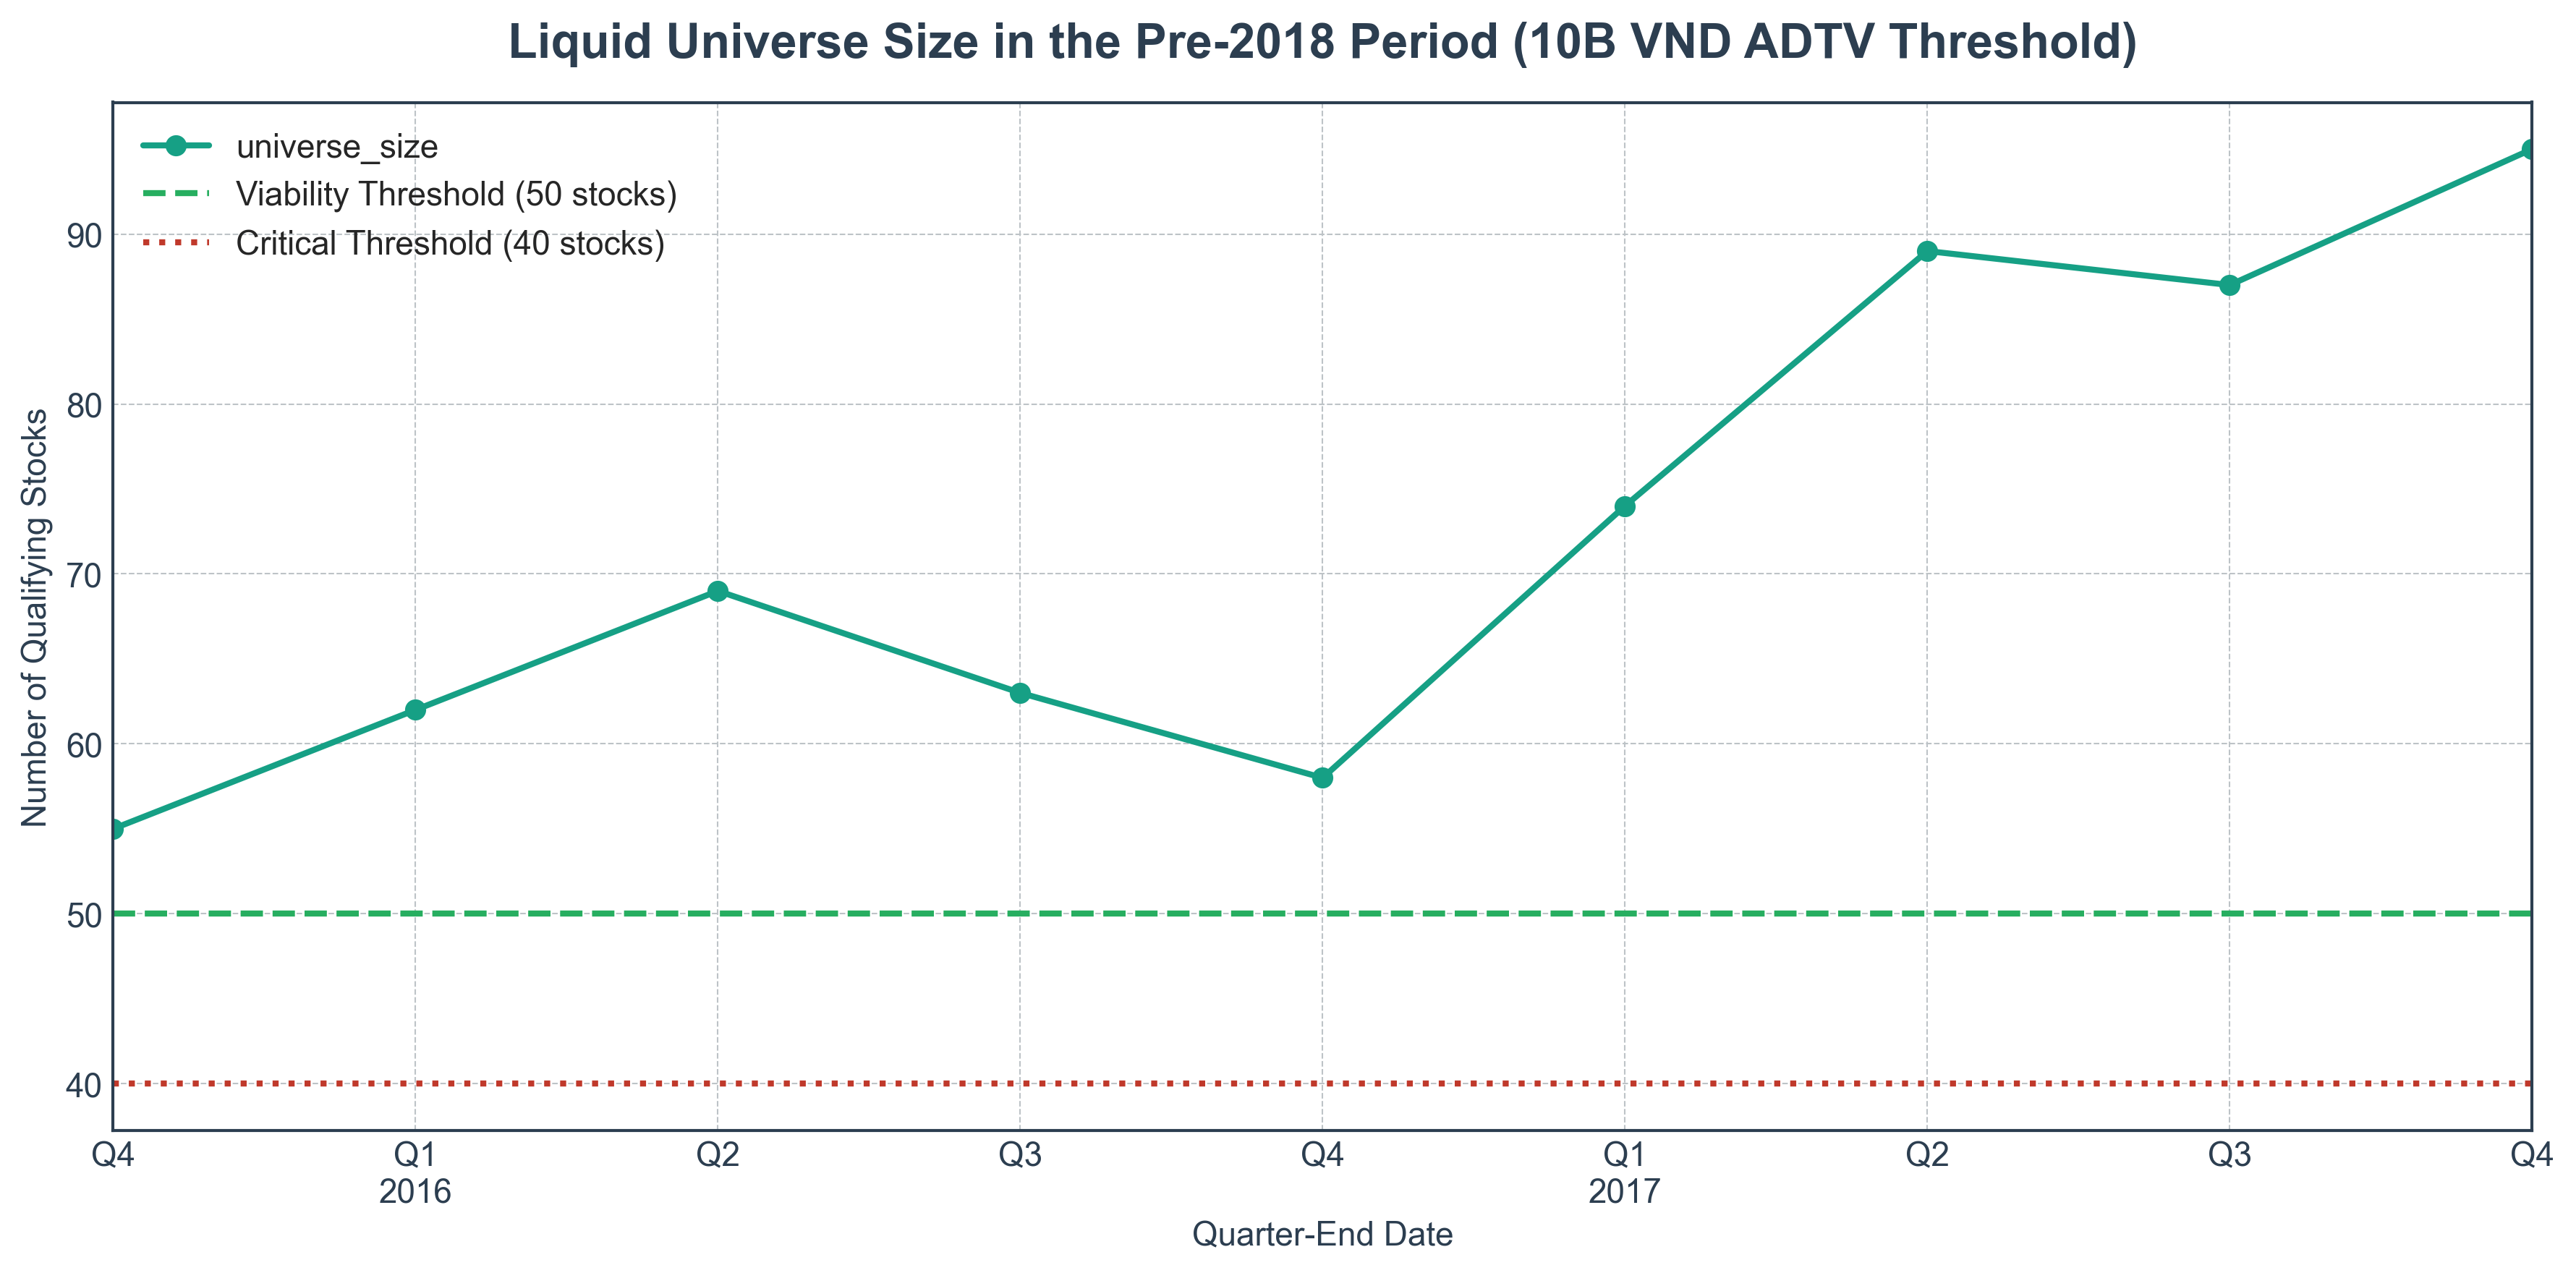

In [2]:
# ============================================================================
# SECTION 1: UNIVERSE VIABILITY ANALYSIS (2016-2017)
# ============================================================================

def create_db_connection():
    """Helper function to establish a database connection."""
    config_path = Path.cwd().parent.parent.parent / 'config' / 'database.yml'
    with open(config_path, 'r') as f:
        db_config = yaml.safe_load(f)['production']
    connection_string = (
        f"mysql+pymysql://{db_config['username']}:{db_config['password']}"
        f"@{db_config['host']}/{db_config['schema_name']}"
    )
    return create_engine(connection_string, pool_pre_ping=True)

engine = create_db_connection()
print("✅ Database connection established for universe analysis.")

# --- 1. Generate the Quarterly Rebalance Dates for the 2016-2017 Period ---
print("\n🗓️  Generating quarterly rebalance dates for 2016-2017...")
pre_2018_rebalance_dates = pd.date_range(start='2015-12-31', end='2017-12-31', freq='Q')
print(f"   - Identified {len(pre_2018_rebalance_dates)} quarter-end dates.")

# --- 2. Construct the Liquid Universe for Each Date ---
print("\n🏗️  Constructing liquid universe for each pre-2018 rebalance date...")
print("   (Using the same 10B VND ADTV threshold for consistency)")

universe_viability_data = []
for rebal_date in pre_2018_rebalance_dates:
    print(f"   - Processing {rebal_date.date()}...")
    try:
        universe_df = get_liquid_universe_dataframe(
            analysis_date=rebal_date,
            engine=engine,
            config={'lookback_days': 63, 'adtv_threshold_bn': 10.0, 'top_n': 200, 'min_trading_coverage': 0.6}
        )
        
        universe_viability_data.append({
            'date': rebal_date,
            'universe_size': len(universe_df),
            'sectors_count': universe_df['sector'].nunique() if not universe_df.empty else 0,
            'median_adtv_bn': universe_df['adtv_bn_vnd'].median() if not universe_df.empty else 0
        })
    except Exception as e:
        print(f"     ERROR constructing universe for {rebal_date.date()}: {e}")
        universe_viability_data.append({
            'date': rebal_date, 'universe_size': 0, 'sectors_count': 0, 'median_adtv_bn': 0
        })

engine.dispose() # Close connection after use
print("\n✅ Universe construction for 2016-2017 complete.")

# --- 3. Analyze and Visualize the Results ---
viability_df = pd.DataFrame(universe_viability_data).set_index('date')

print("\n" + "="*70)
print("📊 UNIVERSE VIABILITY ANALYSIS RESULTS (2016-2017)")
print("="*70)
display(viability_df)

# --- 4. Formulate Verdict ---
avg_universe_size = viability_df['universe_size'].mean()
min_universe_size = viability_df['universe_size'].min()

print("\n" + "="*70)
print("⚖️ VERDICT ON 2016-2017 UNIVERSE VIABILITY")
print("="*70)
print(f"   - Average Universe Size: {avg_universe_size:.0f} stocks")
print(f"   - Minimum Universe Size: {min_universe_size:.0f} stocks")

if min_universe_size >= 50:
    print("\n✅ GO: The liquid universe is consistently large enough (>=50 stocks) for a statistically meaningful backtest.")
    print("   The results from this period can be considered reliable.")
elif avg_universe_size >= 40:
    print("\n🟡 CAUTIOUS GO: The universe size is smaller than ideal but still viable.")
    print("   We will proceed with the backtest but note that the results from this period may have higher variance and be subject to more noise.")
else:
    print("\n❌ NO-GO / HIGH CAUTION: The liquid universe is critically small (<40 stocks on average).")
    print("   The backtest results from this period would be statistically unreliable and potentially misleading.")
    print("   We should consider either lowering the ADTV threshold for this period or excluding it from the final analysis.")

# Visualize the universe size over the period
fig, ax = plt.subplots(figsize=(12, 6))
viability_df['universe_size'].plot(ax=ax, marker='o', linestyle='-', color=PALETTE['primary'])
ax.axhline(50, color=PALETTE['positive'], linestyle='--', label='Viability Threshold (50 stocks)')
ax.axhline(40, color=PALETTE['negative'], linestyle=':', label='Critical Threshold (40 stocks)')

ax.set_title('Liquid Universe Size in the Pre-2018 Period (10B VND ADTV Threshold)', fontweight='bold')
ax.set_ylabel('Number of Qualifying Stocks')
ax.set_xlabel('Quarter-End Date')
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [4]:
# ============================================================================
# SECTION 2: LOAD FULL-PERIOD DATA & DEFINE BACKTESTING ENGINES
# ============================================================================
from typing import Dict, List # Add necessary imports

# --- Helper function to create DB connection ---
def create_db_connection():
    config_path = Path.cwd().parent.parent.parent / 'config' / 'database.yml'
    with open(config_path, 'r') as f:
        db_config = yaml.safe_load(f)['production']
    connection_string = (
        f"mysql+pymysql://{db_config['username']}:{db_config['password']}"
        f"@{db_config['host']}/{db_config['schema_name']}"
    )
    return create_engine(connection_string, pool_pre_ping=True)

# --- Backtesting Engine for Weighted Composite ---
def run_weighted_backtest(
    weighting_scheme: Dict[str, float],
    factor_data_all: pd.DataFrame,
    daily_returns_matrix: pd.DataFrame,
    rebalance_dates: List[pd.Timestamp],
    config: Dict
) -> pd.Series:
    strategy_name = f"W_QVR_{weighting_scheme['Quality']*100:.0f}_{weighting_scheme['Value']*100:.0f}_{weighting_scheme['Reversal']*100:.0f}"
    print(f"\n🚀 EXECUTING BACKTEST: {strategy_name}")
    print("-" * 60)
    all_trading_dates = daily_returns_matrix.index
    daily_holdings = pd.DataFrame(0.0, index=all_trading_dates, columns=daily_returns_matrix.columns)
    for i in range(len(rebalance_dates)):
        rebal_date = rebalance_dates[i]
        factors_on_date = factor_data_all[factor_data_all['rebalance_date'] == rebal_date].copy()
        if len(factors_on_date) < 50: continue
        factors_on_date['Momentum_Reversal'] = -1 * factors_on_date['Momentum_Composite']
        for factor in ['Quality_Composite', 'Value_Composite', 'Momentum_Reversal']:
            mean, std = factors_on_date[factor].mean(), factors_on_date[factor].std()
            if std > 0: factors_on_date[f'{factor}_Z'] = (factors_on_date[factor] - mean) / std
            else: factors_on_date[f'{factor}_Z'] = 0.0
        factors_on_date['Weighted_Composite'] = (
            weighting_scheme['Quality'] * factors_on_date['Quality_Composite_Z'] +
            weighting_scheme['Value'] * factors_on_date['Value_Composite_Z'] +
            weighting_scheme['Reversal'] * factors_on_date['Momentum_Reversal_Z']
        )
        q5_cutoff = factors_on_date['Weighted_Composite'].quantile(0.8)
        q5_stocks = factors_on_date[factors_on_date['Weighted_Composite'] >= q5_cutoff]
        if not q5_stocks.empty:
            weight = 1.0 / len(q5_stocks)
            portfolio_weights = pd.Series(weight, index=q5_stocks['ticker'])
            start_period = rebal_date + pd.Timedelta(days=1)
            end_period = rebalance_dates[i+1] if i + 1 < len(rebalance_dates) else all_trading_dates.max()
            holding_dates = daily_holdings.index[(daily_holdings.index >= start_period) & (daily_holdings.index <= end_period)]
            valid_tickers = portfolio_weights.index.intersection(daily_holdings.columns)
            daily_holdings.loc[holding_dates, valid_tickers] = portfolio_weights[valid_tickers].values
    holdings_shifted = daily_holdings.shift(1).fillna(0.0)
    gross_returns = (holdings_shifted * daily_returns_matrix).sum(axis=1)
    turnover = (holdings_shifted - holdings_shifted.shift(1)).abs().sum(axis=1) / 2
    costs = turnover * (config['transaction_cost_bps'] / 10000)
    net_returns = gross_returns - costs
    print(f"   ✅ {strategy_name} backtest complete.")
    return net_returns.rename(strategy_name)

# --- Backtesting Engine for Single Factor ---
def run_single_factor_backtest(
    factor_name: str,
    factor_data_all: pd.DataFrame,
    daily_returns_matrix: pd.DataFrame,
    rebalance_dates: List[pd.Timestamp],
    config: Dict
) -> pd.Series:
    strategy_name = f"Standalone_{factor_name}"
    print(f"\n🚀 EXECUTING BACKTEST: {strategy_name}")
    print("-" * 60)
    all_trading_dates = daily_returns_matrix.index
    daily_holdings = pd.DataFrame(0.0, index=all_trading_dates, columns=daily_returns_matrix.columns)
    for i in range(len(rebalance_dates)):
        rebal_date = rebalance_dates[i]
        factors_on_date = factor_data_all[factor_data_all['rebalance_date'] == rebal_date].copy()
        if len(factors_on_date) < 50: continue
        factors_on_date['signal'] = factors_on_date[factor_name]
        q5_cutoff = factors_on_date['signal'].quantile(0.8)
        q5_stocks = factors_on_date[factors_on_date['signal'] >= q5_cutoff]
        if not q5_stocks.empty:
            weight = 1.0 / len(q5_stocks)
            portfolio_weights = pd.Series(weight, index=q5_stocks['ticker'])
            start_period = rebal_date + pd.Timedelta(days=1)
            end_period = rebalance_dates[i+1] if i + 1 < len(rebalance_dates) else all_trading_dates.max()
            holding_dates = daily_holdings.index[(daily_holdings.index >= start_period) & (daily_holdings.index <= end_period)]
            valid_tickers = portfolio_weights.index.intersection(daily_holdings.columns)
            daily_holdings.loc[holding_dates, valid_tickers] = portfolio_weights[valid_tickers].values
    holdings_shifted = daily_holdings.shift(1).fillna(0.0)
    gross_returns = (holdings_shifted * daily_returns_matrix).sum(axis=1)
    turnover = (holdings_shifted - holdings_shifted.shift(1)).abs().sum(axis=1) / 2
    costs = turnover * (config['transaction_cost_bps'] / 10000)
    net_returns = gross_returns - costs
    print(f"   ✅ {strategy_name} backtest complete.")
    return net_returns.rename(strategy_name)

# --- 1. Database Connection & Full Data Loading ---
print("📂 Loading all raw data for the full 2016-2025 backtest period...")
engine = create_db_connection()
db_params = {'start_date': CONFIG['backtest_start'], 'end_date': CONFIG['backtest_end']}
factor_query = text("SELECT date, ticker, Quality_Composite, Value_Composite, Momentum_Composite FROM factor_scores_qvm WHERE date BETWEEN :start_date AND :end_date AND strategy_version = 'qvm_v2.0_enhanced'")
factor_data_raw = pd.read_sql(factor_query, engine, params=db_params, parse_dates=['date'])
print(f"   ✅ Loaded {len(factor_data_raw):,} raw factor observations.")
price_query = text("SELECT date, ticker, close FROM equity_history WHERE date BETWEEN :start_date AND :end_date")
price_data_raw = pd.read_sql(price_query, engine, params=db_params, parse_dates=['date'])
price_data_raw['return'] = price_data_raw.groupby('ticker')['close'].pct_change()
daily_returns_matrix = price_data_raw.pivot(index='date', columns='ticker', values='return')
print(f"   ✅ Loaded and processed {len(price_data_raw):,} raw price observations.")
benchmark_query = text("SELECT date, close FROM etf_history WHERE ticker = 'VNINDEX' AND date BETWEEN :start_date AND :end_date")
benchmark_data_raw = pd.read_sql(benchmark_query, engine, params=db_params, parse_dates=['date'])
benchmark_returns = benchmark_data_raw.set_index('date')['close'].pct_change().rename('VN-Index')
print(f"   ✅ Loaded {len(benchmark_data_raw):,} benchmark observations.")

# --- 2. Define the Full Rebalance Schedule ---
all_trading_dates = daily_returns_matrix.index
full_quarter_ends = pd.date_range(start=CONFIG['backtest_start'], end=CONFIG['backtest_end'], freq='Q')
full_rebalance_dates = [
    all_trading_dates[all_trading_dates.searchsorted(q_end, side='right') - 1]
    for q_end in full_quarter_ends if q_end <= all_trading_dates.max() and q_end >= all_trading_dates.min()
]
print(f"\n   ✅ Generated {len(full_rebalance_dates)} data-driven rebalance dates for the full period.")

# --- 3. Execute Backtests ---
# Execute Weighted QVR Backtest
extended_weighted_qvr_returns = run_weighted_backtest(
    weighting_scheme=CONFIG['weighting_scheme'],
    factor_data_all=factor_data_raw.rename(columns={'date': 'rebalance_date'}),
    daily_returns_matrix=daily_returns_matrix,
    rebalance_dates=full_rebalance_dates,
    config=CONFIG
)

# Execute Standalone Value Backtest
extended_value_returns = run_single_factor_backtest(
    factor_name='Value_Composite',
    factor_data_all=factor_data_raw.rename(columns={'date': 'rebalance_date'}),
    daily_returns_matrix=daily_returns_matrix,
    rebalance_dates=full_rebalance_dates,
    config=CONFIG
)

engine.dispose()
print("\n✅ All extended backtests executed. Ready for final comparative analysis.")

📂 Loading all raw data for the full 2016-2025 backtest period...
   ✅ Loaded 1,567,488 raw factor observations.
   ✅ Loaded and processed 1,623,168 raw price observations.
   ✅ Loaded 2,411 benchmark observations.

   ✅ Generated 39 data-driven rebalance dates for the full period.

🚀 EXECUTING BACKTEST: W_QVR_20_60_20
------------------------------------------------------------
   ✅ W_QVR_20_60_20 backtest complete.

🚀 EXECUTING BACKTEST: Standalone_Value_Composite
------------------------------------------------------------
   ✅ Standalone_Value_Composite backtest complete.

✅ All extended backtests executed. Ready for final comparative analysis.



🏆 INSTITUTIONAL TEARSHEET: STANDALONE VALUE (2016-2025)


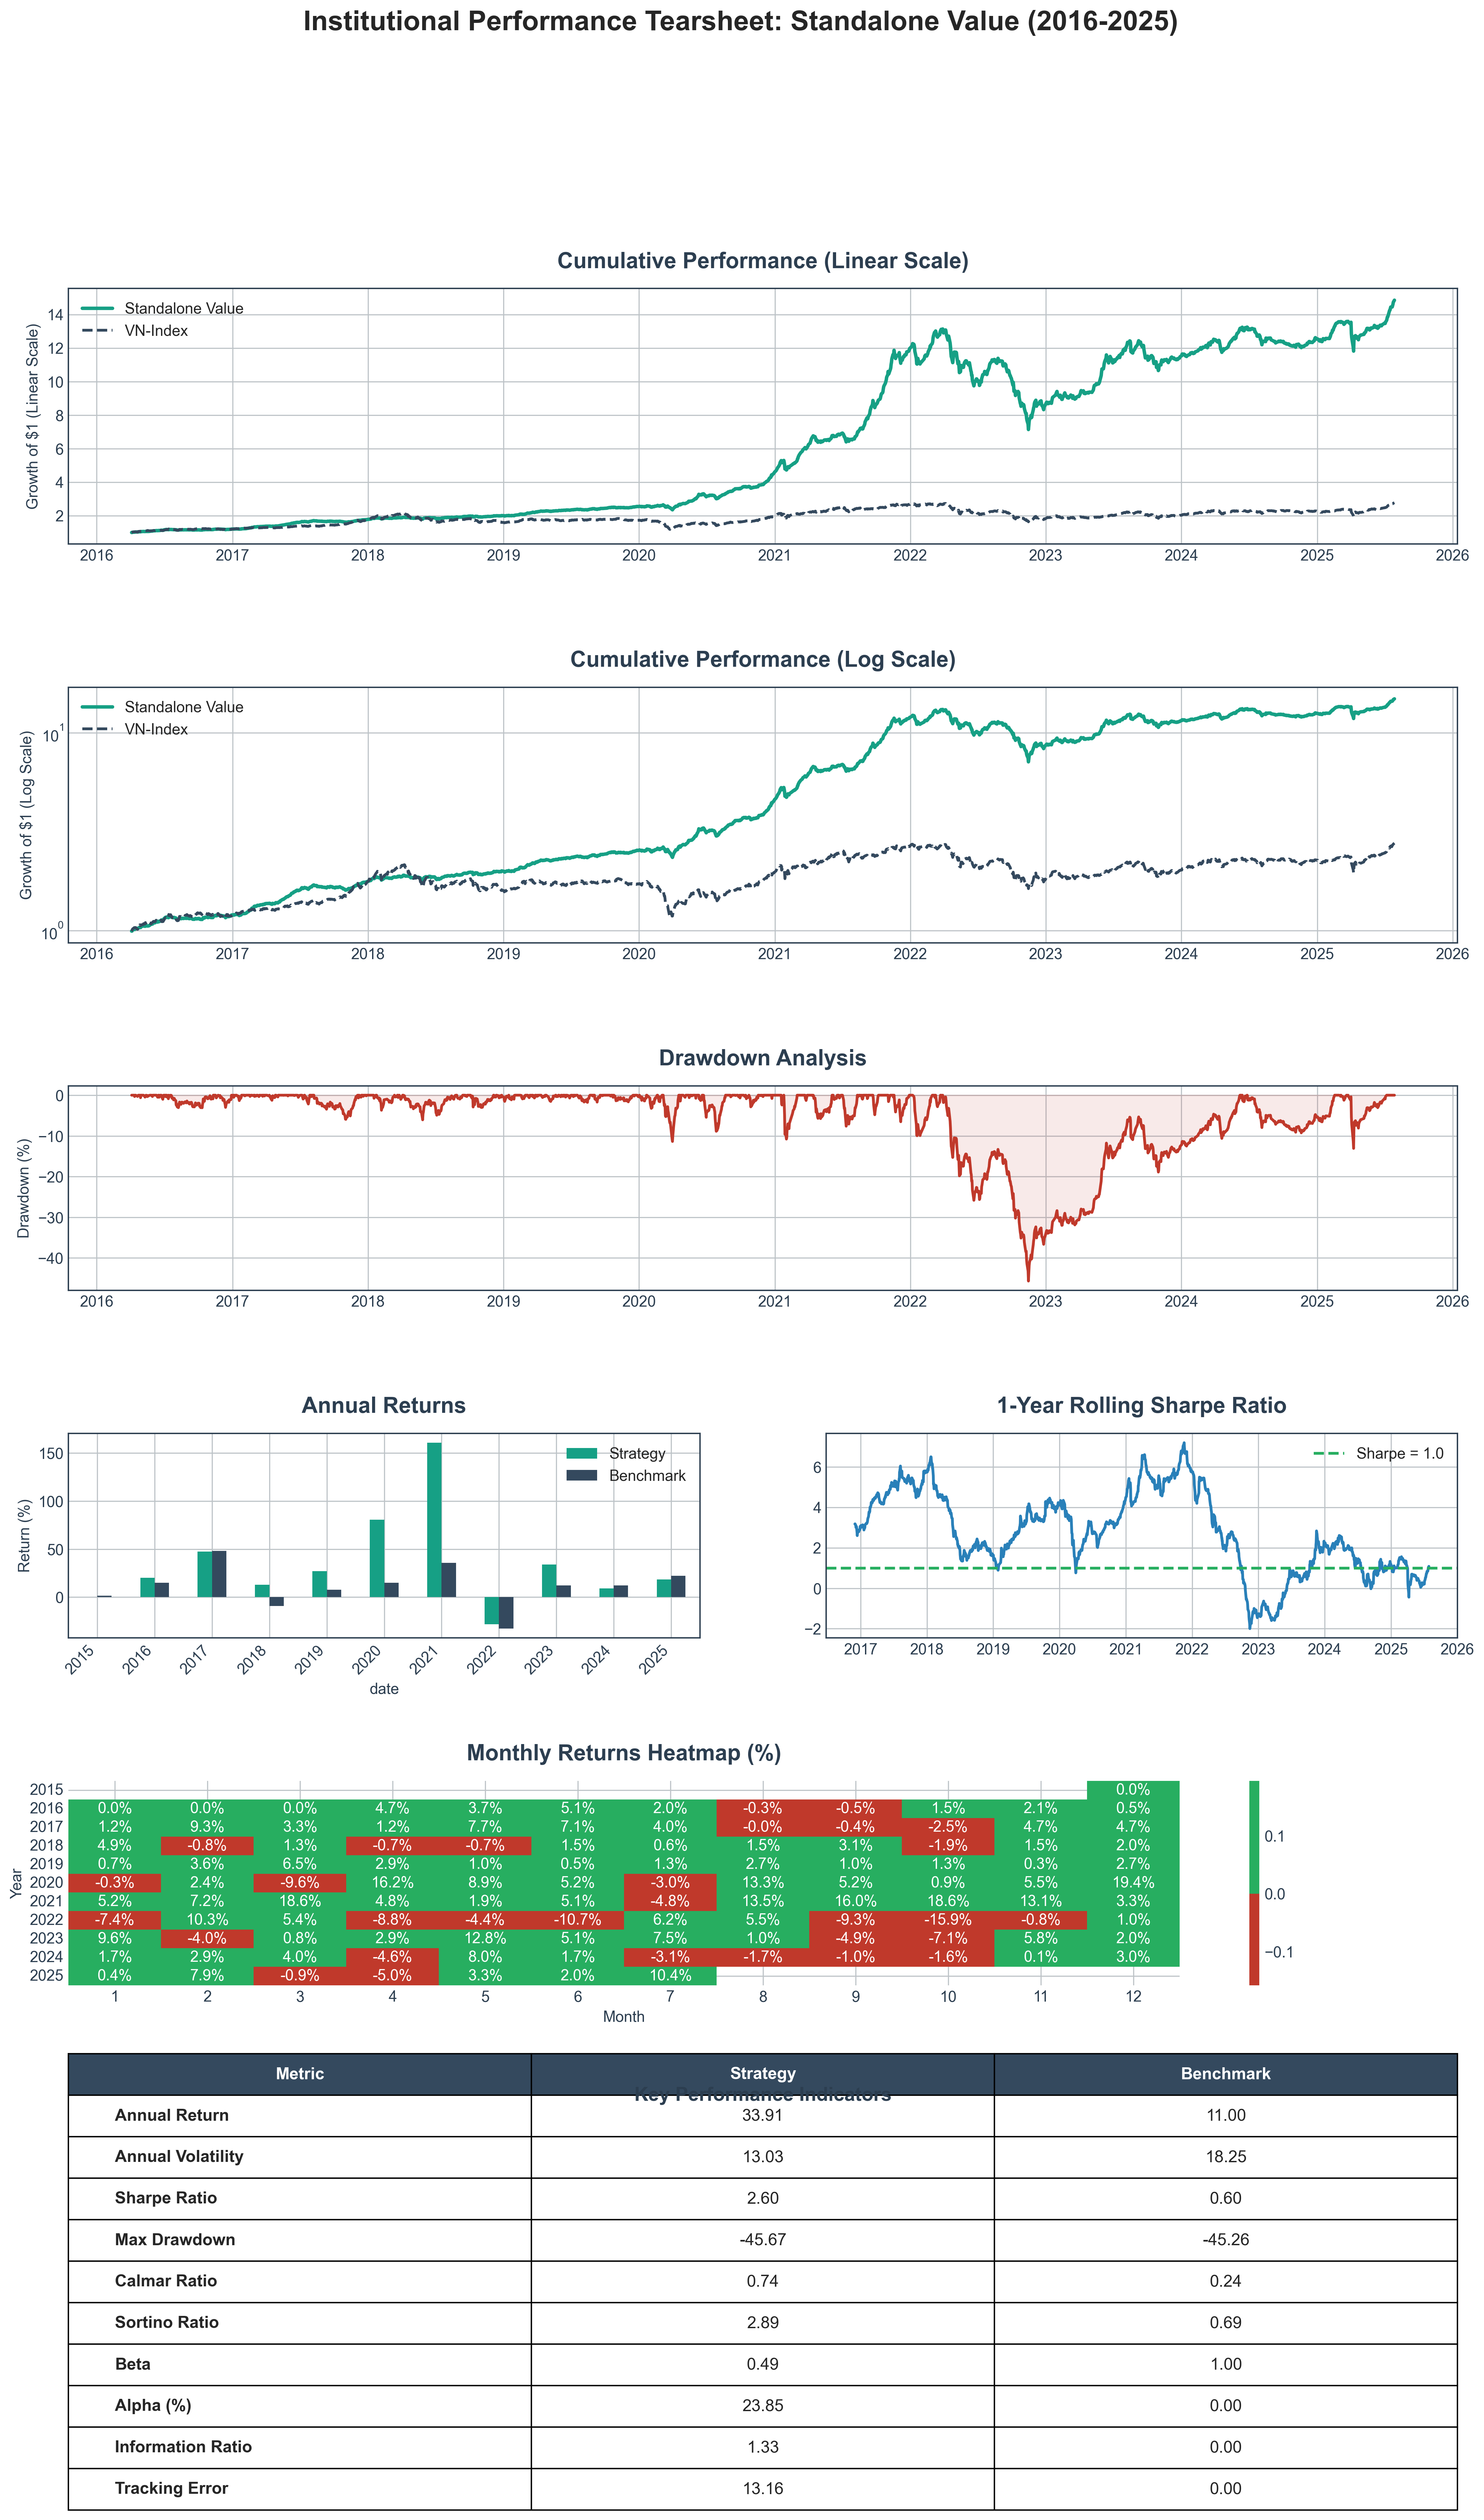


🔬 INSTITUTIONAL TEARSHEET: WEIGHTED QVR (60/20/20) (2016-2025)


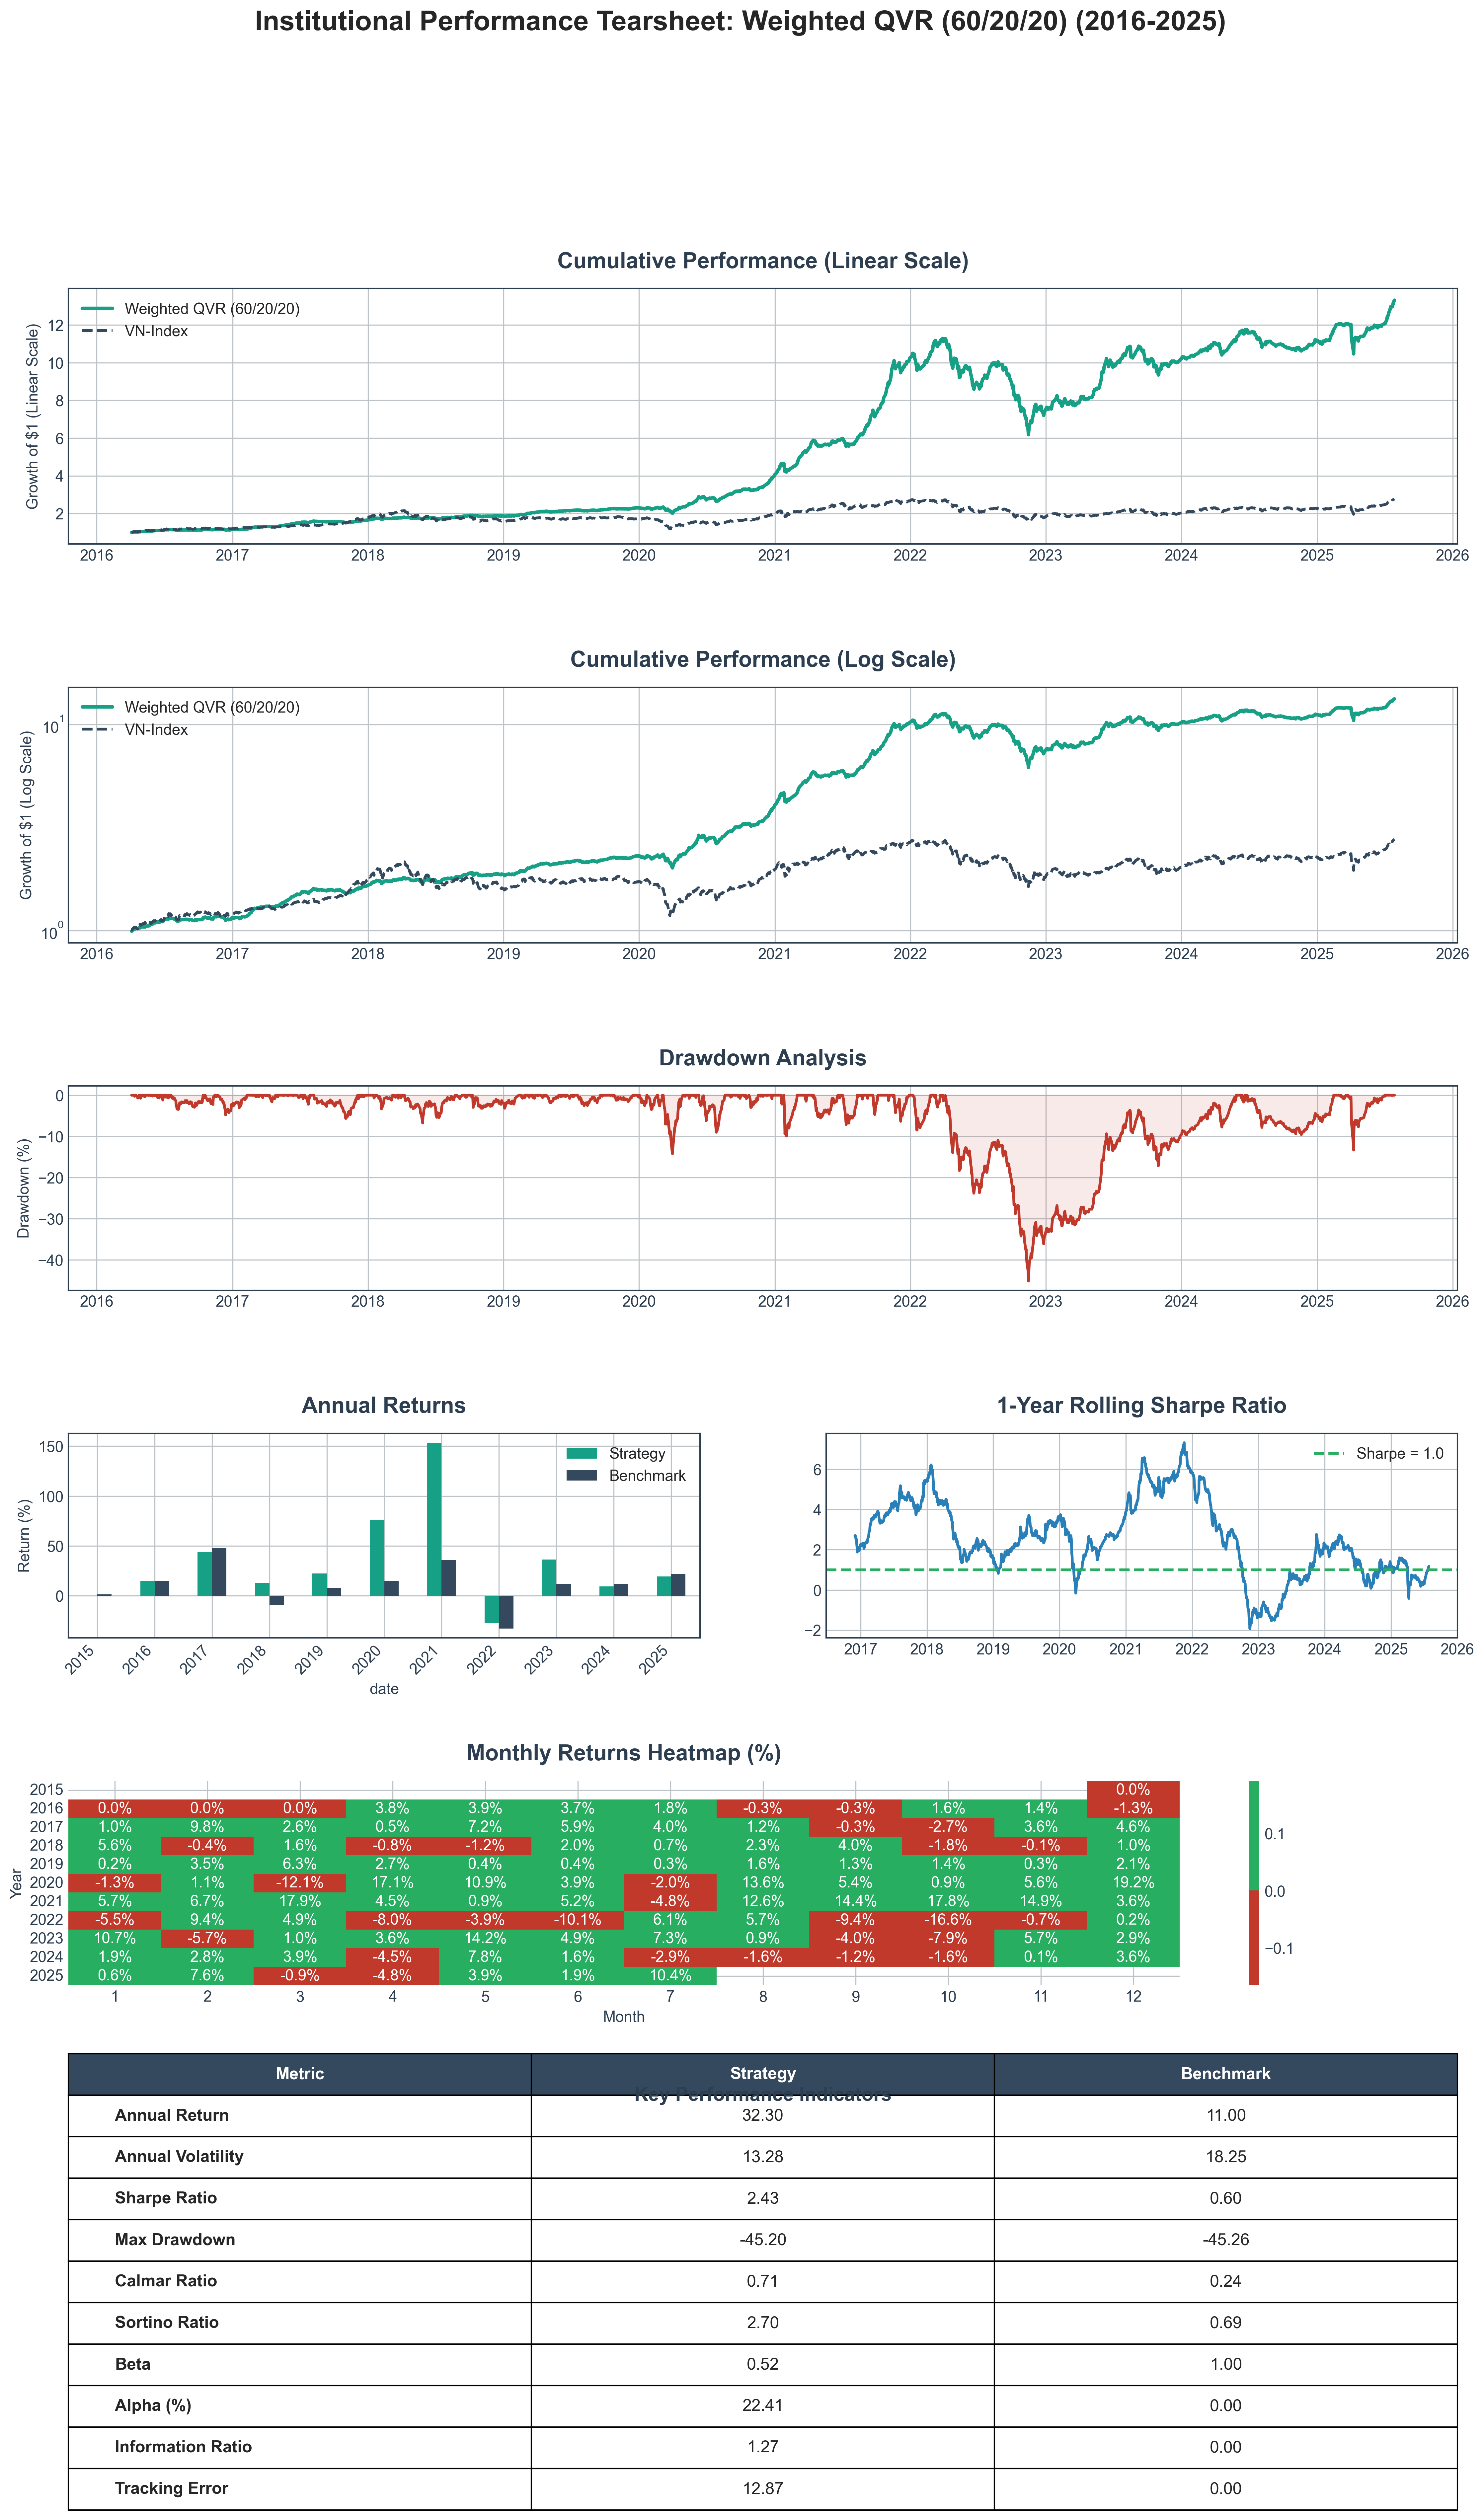

In [7]:
# ============================================================================
# SECTION 3: FINAL TEARSHEET & STRATEGIC VERDICT (2016-2025) - CORRECTED
# ============================================================================
from typing import Dict, List # Add necessary imports for self-contained cell

def calculate_full_performance_metrics(returns, benchmark, risk_free_rate=0.0):
    """Calculates a comprehensive set of institutional-grade performance metrics."""
    first_trade_date = returns.loc[returns != 0].index.min()
    common_index = returns.loc[first_trade_date:].index.intersection(benchmark.index)
    returns, benchmark = returns.loc[common_index], benchmark.loc[common_index]

    n_years = len(returns) / 252
    total_return = (1 + returns).prod() - 1
    annual_return = (1 + total_return) ** (1 / n_years) - 1 if n_years > 0 else 0
    annual_vol = returns.std() * np.sqrt(252)
    sharpe_ratio = (annual_return - risk_free_rate) / annual_vol if annual_vol > 0 else 0
    
    cumulative = (1 + returns).cumprod()
    drawdown = (cumulative / cumulative.cummax() - 1)
    max_drawdown = drawdown.min()
    calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown < 0 else 0
    
    downside_returns = returns[returns < 0]
    downside_vol = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0
    sortino_ratio = (annual_return - risk_free_rate) / downside_vol if downside_vol > 0 else 0
    
    excess_returns = returns - benchmark
    tracking_error = excess_returns.std() * np.sqrt(252)
    information_ratio = (excess_returns.mean() * 252) / tracking_error if tracking_error > 0 else 0
    
    cov_matrix = np.cov(returns.fillna(0), benchmark.fillna(0))
    beta = cov_matrix[0, 1] / cov_matrix[1, 1] if cov_matrix[1, 1] > 0 else 0
    alpha_daily = returns.mean() - beta * benchmark.mean()
    alpha_annualized = alpha_daily * 252
    
    return {
        'Annual Return': annual_return * 100, 'Annual Volatility': annual_vol * 100,
        'Sharpe Ratio': sharpe_ratio, 'Max Drawdown': max_drawdown * 100,
        'Calmar Ratio': calmar_ratio, 'Sortino Ratio': sortino_ratio,
        'Beta': beta, 'Alpha (%)': alpha_annualized * 100,
        'Information Ratio': information_ratio, 'Tracking Error': tracking_error * 100
    }

def create_institutional_tearsheet(strategy_returns, benchmark_returns, strategy_name):
    """Generates a comprehensive, quantstats-style performance tearsheet."""
    portfolio_metrics = calculate_full_performance_metrics(strategy_returns, benchmark_returns)
    benchmark_metrics = calculate_full_performance_metrics(benchmark_returns, benchmark_returns)
    
    fig = plt.figure(figsize=(18, 28))
    gs = fig.add_gridspec(6, 2, height_ratios=[1, 1, 0.8, 0.8, 0.8, 1.2], hspace=0.6, wspace=0.2)
    fig.suptitle(f'Institutional Performance Tearsheet: {strategy_name} (2016-2025)', fontsize=20, fontweight='bold')

    first_trade_date = strategy_returns.loc[strategy_returns != 0].index.min()
    strategy_cum = (1 + strategy_returns.loc[first_trade_date:]).cumprod()
    benchmark_cum = (1 + benchmark_returns.loc[first_trade_date:]).cumprod()

    # Plot 1 & 2: Cumulative Performance (Linear & Log)
    for i, scale in enumerate(['Linear', 'Log']):
        ax = fig.add_subplot(gs[i, :])
        ax.plot(strategy_cum.index, strategy_cum, label=strategy_name, color=PALETTE['primary'], linewidth=2.5)
        ax.plot(benchmark_cum.index, benchmark_cum, label='VN-Index', color=PALETTE['secondary'], linestyle='--', linewidth=2)
        if scale == 'Log': ax.set_yscale('log')
        ax.set_title(f'Cumulative Performance ({scale} Scale)', fontweight='bold')
        ax.set_ylabel(f'Growth of $1 ({scale} Scale)')
        ax.legend(loc='upper left')

    # Plot 3: Drawdown Analysis
    ax3 = fig.add_subplot(gs[2, :])
    strategy_dd = (strategy_cum / strategy_cum.cummax() - 1) * 100
    ax3.plot(strategy_dd.index, strategy_dd, color=PALETTE['negative'], linewidth=2)
    ax3.fill_between(strategy_dd.index, strategy_dd, 0, color=PALETTE['negative'], alpha=0.1)
    ax3.set_title('Drawdown Analysis', fontweight='bold'); ax3.set_ylabel('Drawdown (%)')

    # Plot 4 & 5: Annual Returns & Rolling Sharpe
    ax4 = fig.add_subplot(gs[3, 0])
    strat_annual = strategy_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100
    bench_annual = benchmark_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100
    pd.DataFrame({'Strategy': strat_annual, 'Benchmark': bench_annual}).plot(kind='bar', ax=ax4, color=[PALETTE['primary'], PALETTE['secondary']])
    ax4.set_xticklabels([d.strftime('%Y') for d in strat_annual.index], rotation=45, ha='right'); ax4.set_title('Annual Returns', fontweight='bold'); ax4.set_ylabel('Return (%)')

    ax5 = fig.add_subplot(gs[3, 1])
    rolling_sharpe = (strategy_returns.rolling(252).mean() * 252) / (strategy_returns.rolling(252).std() * np.sqrt(252))
    ax5.plot(rolling_sharpe.index, rolling_sharpe, color=PALETTE['highlight_1']); ax5.axhline(1.0, color=PALETTE['positive'], linestyle='--', label='Sharpe = 1.0'); ax5.set_title('1-Year Rolling Sharpe Ratio', fontweight='bold'); ax5.legend()

    # Plot 6: Monthly Returns Heatmap
    ax6 = fig.add_subplot(gs[4, :])
    monthly_returns = strategy_returns.resample('M').apply(lambda x: (1+x).prod()-1)
    monthly_pivot = monthly_returns.to_frame('ret').pivot_table(index=monthly_returns.index.year, columns=monthly_returns.index.month, values='ret')
    
    # *** CRITICAL FIX: Pass a list of colors, not a concatenated string ***
    heatmap_palette = sns.color_palette([PALETTE['negative'], PALETTE['positive']], as_cmap=True)
    sns.heatmap(monthly_pivot, ax=ax6, annot=True, fmt='.1%', cmap=heatmap_palette, center=0)
    ax6.set_title('Monthly Returns Heatmap (%)', fontweight='bold'); ax6.set_xlabel('Month'); ax6.set_ylabel('Year')

    # Table: Performance Statistics
    ax7 = fig.add_subplot(gs[5, :]); ax7.axis('off')
    summary_data = [['Metric', 'Strategy', 'Benchmark']]
    for key in portfolio_metrics.keys():
        summary_data.append([key, f"{portfolio_metrics[key]:.2f}", f"{benchmark_metrics.get(key, 0.0):.2f}"])
    table = ax7.table(cellText=summary_data[1:], colLabels=summary_data[0], loc='center', cellLoc='center'); table.auto_set_font_size(False); table.set_fontsize(12); table.scale(1, 2.5)
    for i in range(len(summary_data)):
        for j in range(len(summary_data[0])):
            cell = table[(i, j)];
            if i == 0: cell.set_facecolor(PALETTE['secondary']); cell.set_text_props(weight='bold', color='white')
            elif j == 0: cell.set_text_props(weight='bold', ha='left')
            else: cell.set_text_props(ha='center')
    ax7.set_title('Key Performance Indicators', fontweight='bold', fontsize=14, pad=20)
    
    plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.show()

# --- Generate Tearsheets for Both Strategies ---
print("\n" + "="*80)
print("🏆 INSTITUTIONAL TEARSHEET: STANDALONE VALUE (2016-2025)")
print("="*80)
create_institutional_tearsheet(extended_value_returns, benchmark_returns, "Standalone Value")

print("\n" + "="*80)
print("🔬 INSTITUTIONAL TEARSHEET: WEIGHTED QVR (60/20/20) (2016-2025)")
print("="*80)
create_institutional_tearsheet(extended_weighted_qvr_returns, benchmark_returns, "Weighted QVR (60/20/20)")

In [8]:
# ============================================================================
# SECTION 4: PERSIST RESULTS FOR PHASE 17 VALIDATION
# ============================================================================

print("💾 Saving final backtest results for Phase 17...")

# --- Create the results package ---
phase16b_results = {
    'standalone_value_returns': extended_value_returns,
    'weighted_qvr_returns': extended_weighted_qvr_returns,
    'benchmark_returns': benchmark_returns,
    'strategy_metrics': summary_df_full,
    'timestamp': datetime.now()
}

# --- Define save path and save the file ---
project_root = Path.cwd().parent.parent
save_path = project_root / "tests" / "phase16_weighted_composite_model"
save_path.mkdir(exist_ok=True) # Ensure the directory exists
results_file = save_path / "phase16b_results.pkl"

with open(results_file, "wb") as f:
    pickle.dump(phase16b_results, f)

print(f"\n✅ Results successfully saved to:")
print(f"   {results_file}")
print(f"   File size: {results_file.stat().st_size / 1024:.1f} KB")
print("\n✅ Ready to proceed to Phase 17.")

💾 Saving final backtest results for Phase 17...

✅ Results successfully saved to:
   /Users/ducnguyen/Library/CloudStorage/GoogleDrive-duc.nguyentcb@gmail.com/My Drive/quant-world-invest/factor_investing_project/production/tests/phase16_weighted_composite_model/phase16b_results.pkl
   File size: 152.9 KB

✅ Ready to proceed to Phase 17.
